# Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, LogLocator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
players = pd.read_csv("../data/players_cleaned.csv")

In [3]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31046 entries, 0 to 31045
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             31046 non-null  int64  
 1   first_name                            31046 non-null  object 
 2   last_name                             31046 non-null  object 
 3   name                                  31046 non-null  object 
 4   last_season                           31046 non-null  int64  
 5   current_club_id                       31046 non-null  int64  
 6   player_code                           31046 non-null  object 
 7   city_of_birth                         31046 non-null  object 
 8   country_of_citizenship                31046 non-null  object 
 9   date_of_birth                         31046 non-null  object 
 10  sub_position                          31046 non-null  object 
 11  position       

# 1️⃣ Datenqualität & Überblick

<Axes: >

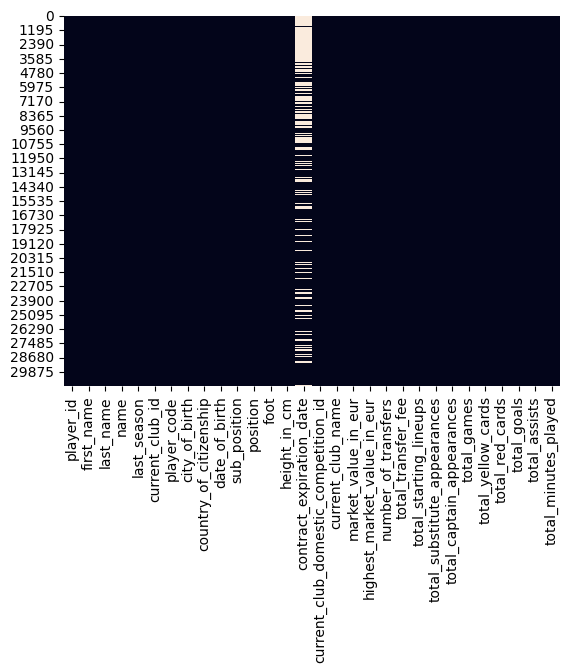

In [4]:
sns.heatmap(players.isna(), cbar=False)

- 'contract_expiration_date' noch genauer anschauen in der EDA --> These: welche die eine Laufzeit haben, haben die einen höheren Marktwert?

## Spalte 'age' erstellen

In [5]:
today = pd.Timestamp.today()

players["date_of_birth"] = pd.to_datetime(players["date_of_birth"])

players["age"] = players["date_of_birth"].apply(
    lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
)

In [6]:
players[["player_code","date_of_birth", "age"]].sort_values(ascending=True, by="age").head(10)

player_code date_of_birth  age
30989      semm-renders    2007-12-17   17
30799     honest-ahanor    2008-02-23   17
30367    brad-manguelle    2007-11-27   17
30789       viggo-gebel    2007-11-22   17
30786    kyrylo-digtyar    2007-11-25   17
31011       evan-mooney    2007-12-11   17
30987     ibrahim-mbaye    2008-01-24   17
30509      david-otorbi    2007-10-16   17
30896        emir-daduk    2008-02-13   17
30879  youssef-hamdaoui    2008-03-20   17

## Laufzeit des bestehenden Vertrags als Spalte erstellen

In [7]:
players[players["contract_expiration_date"].notna()].contract_expiration_date

9        2023-12-31 00:00:00
94       2023-06-30 00:00:00
118      2023-12-31 00:00:00
145      2024-06-30 00:00:00
183      2025-06-30 00:00:00
                ...         
31040    2026-06-30 00:00:00
31041    2027-06-30 00:00:00
31042    2027-06-30 00:00:00
31043    2026-06-30 00:00:00
31045    2029-06-30 00:00:00
Name: contract_expiration_date, Length: 19770, dtype: object

In [8]:
players["contract_expiration_date"] = pd.to_datetime(players["contract_expiration_date"])

today = pd.Timestamp.today()

players["contract_years_left"] = players["contract_expiration_date"].apply(
    lambda x: max(0, round((x - today).days / 365, 1)) if pd.notnull(x) else 0
)

In [9]:
players[["player_code","contract_expiration_date", "contract_years_left"]].sort_values(ascending=False, by="contract_years_left").head(10)

player_code contract_expiration_date  contract_years_left
21261     erling-haaland               2034-06-30                  8.7
24901        cole-palmer               2033-06-30                  7.7
30511     mathis-amougou               2033-06-30                  7.7
28600    nicolas-jackson               2033-06-30                  7.7
24993       oihan-sancet               2032-06-30                  6.7
26649     enzo-fernandez               2032-06-30                  6.7
23820        dani-vivian               2032-06-30                  6.7
24202    mykhaylo-mudryk               2031-06-30                  5.7
23868  maximilian-kilman               2031-06-30                  5.7
30927    aaron-anselmino               2031-06-30                  5.7

## Numerische Werte

In [10]:
numerics_columns = [
    'last_season',
    'height_in_cm',
    'market_value_in_eur',
    'highest_market_value_in_eur',
    'number_of_transfers',
    'total_transfer_fee',
    'total_starting_lineups',
    'total_substitute_appearances',
    'total_captain_appearances',
    'total_games',
    'total_yellow_cards',
    'total_red_cards',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'age',
    'contract_years_left'
]

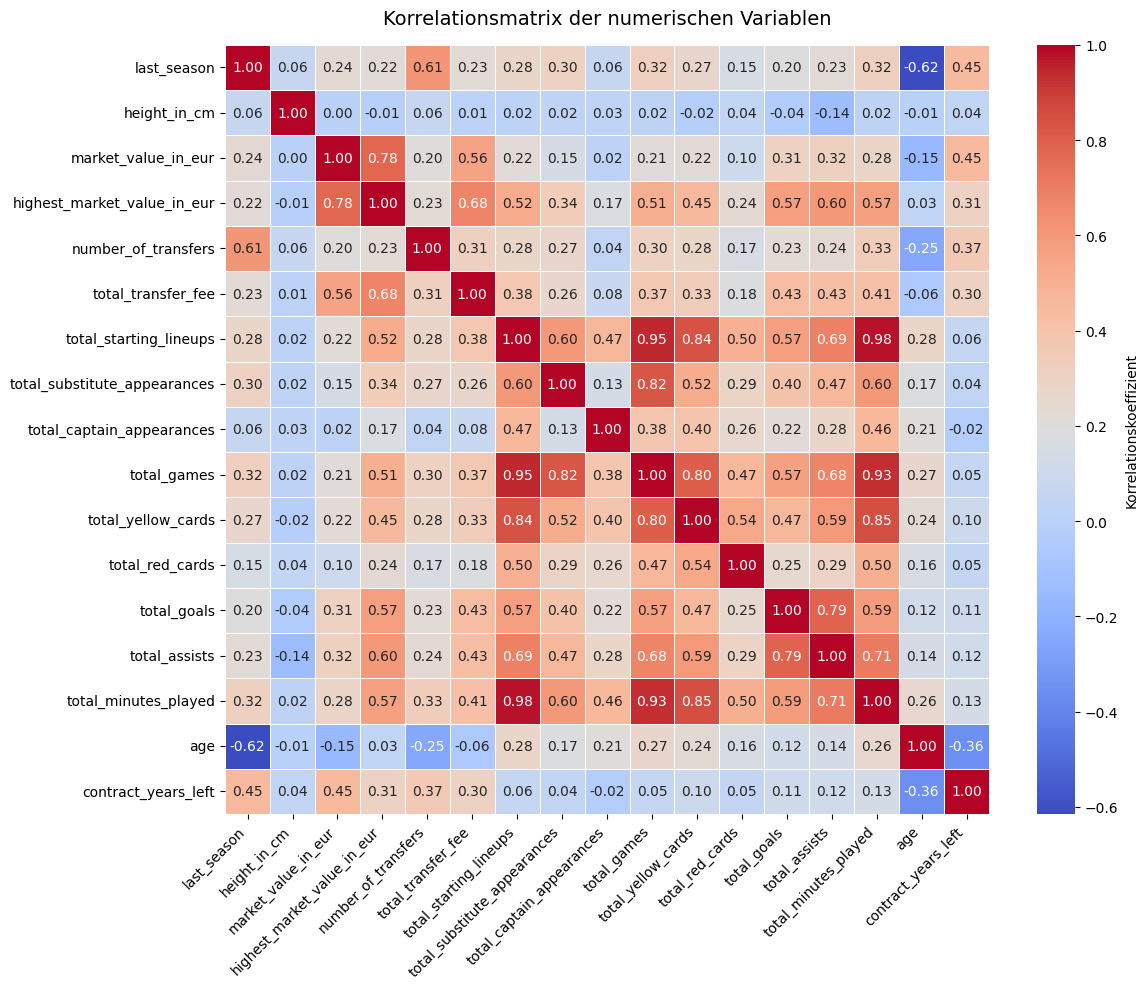

In [11]:
corr = players[numerics_columns].corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Korrelationskoeffizient'}
)
plt.title("Korrelationsmatrix der numerischen Variablen", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- market_value_in_eur korreliert am stärksten mit:
    - highest_market_value_in_eur (r = 0.78) → logisch: historisch höchster Wert hängt eng mit aktuellem Marktwert zusammen.
	- total_goals (r ≈ 0.57) und total_assists (r ≈ 0.56) → Leistung (Torbeteiligungen) beeinflusst den Marktwert deutlich.
	- total_games (r ≈ 0.51) und total_starting_lineups (r ≈ 0.52) → Spielpraxis ist ein starker Indikator.
	- total_minutes_played (r ≈ 0.50) → Einsatzzeit als verlässliches Leistungsmaß.
	- contract_years_left (r ≈ 0.45) → längere Vertragslaufzeit = höherer Marktwert (Vereine sichern wertvolle Spieler länger).

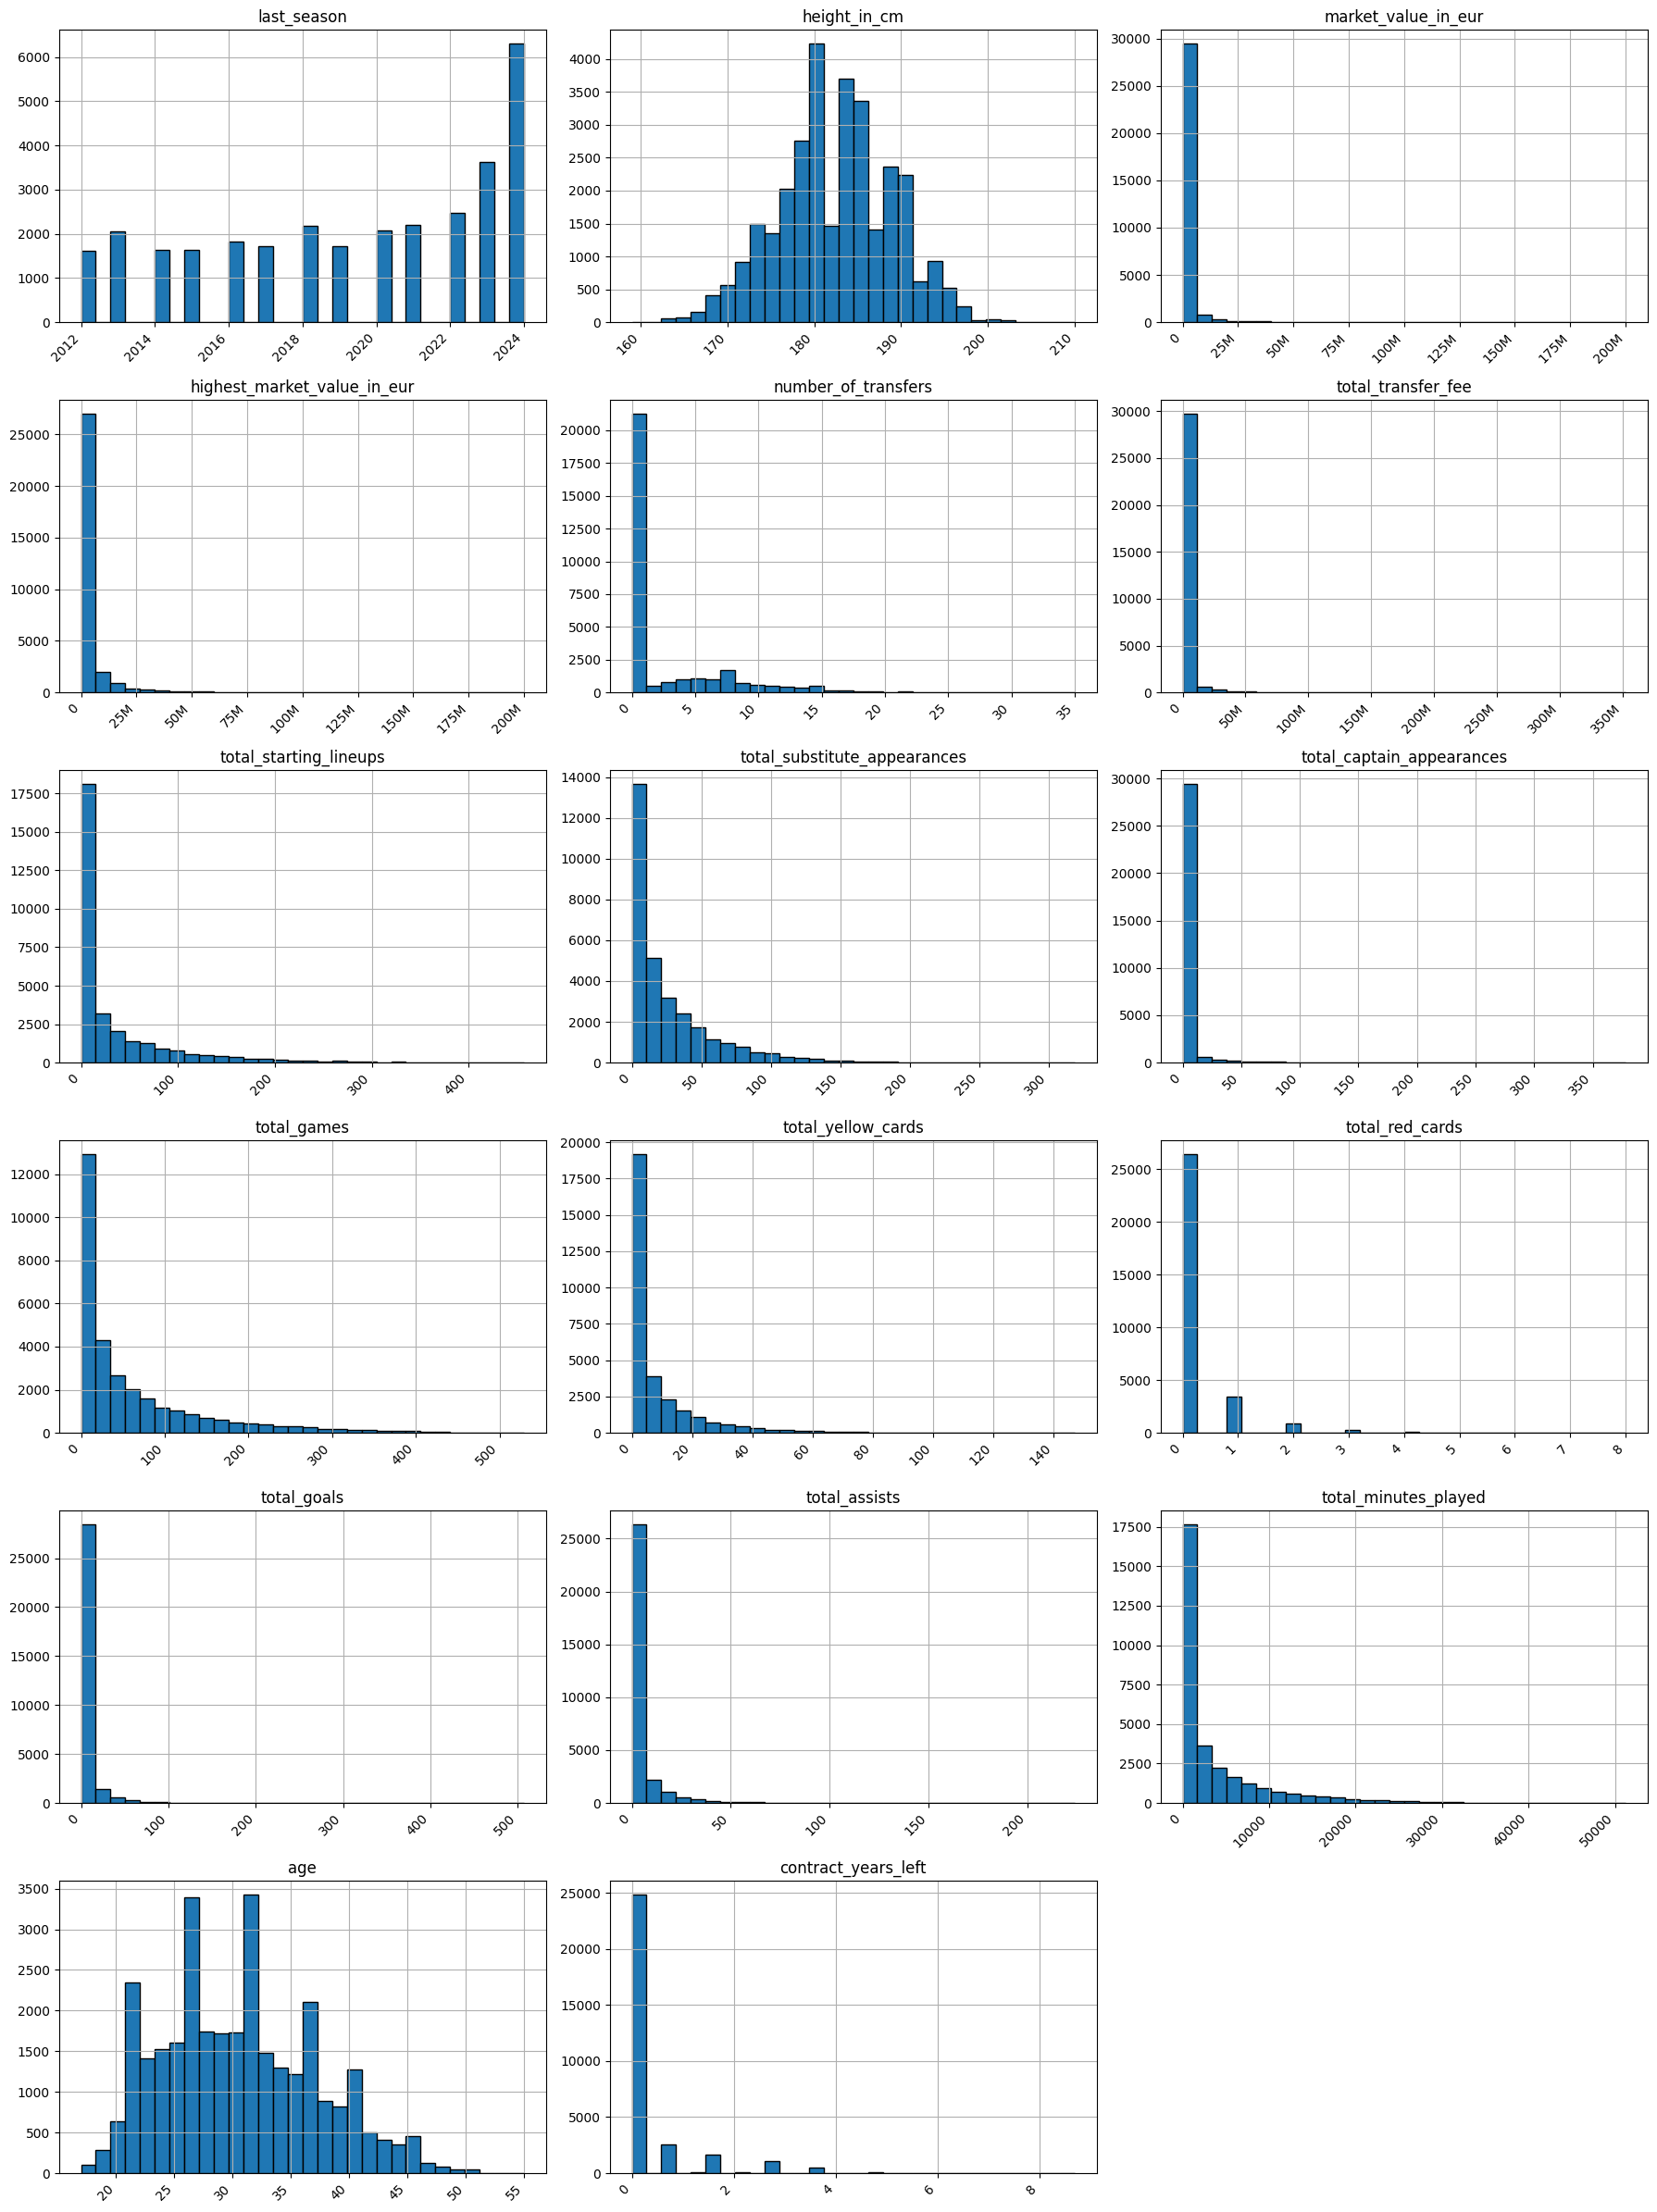

In [12]:
n = len(numerics_columns)
rows = (n // 3) + 1
fig, axes = plt.subplots(rows, 3, figsize=(18, rows*4))
axes = axes.flatten()

for i, col in enumerate(numerics_columns):
    players[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)

    if col in ["market_value_in_eur", "highest_market_value_in_eur", "total_transfer_fee"]:
        axes[i].xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f'{int(x/1e6)}M' if x >= 1e6 else
                                                (f'{int(x/1e3)}K' if x >= 1e3 else f'{int(x)}'))
        )

    if col == "last_season":
        axes[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

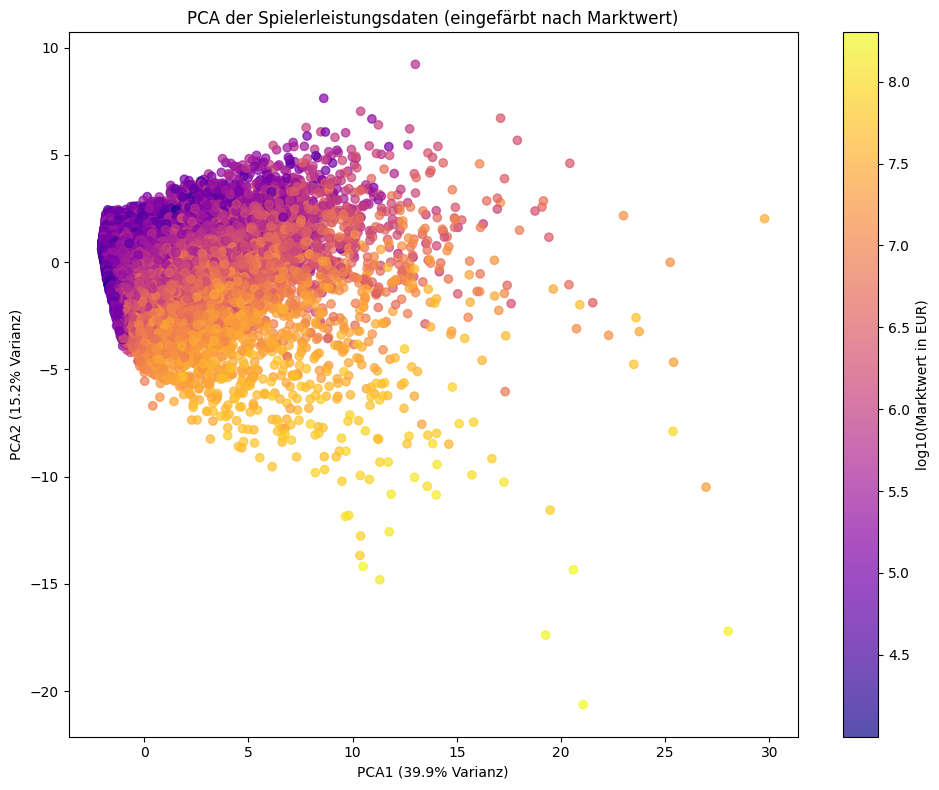

In [ ]:
X = players[numerics_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "market_value_in_eur": players["market_value_in_eur"],
    "position": players["position"]
})

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    pca_df["PCA1"],
    pca_df["PCA2"],
    c=np.log10(pca_df["market_value_in_eur"] + 1),
    cmap="plasma",
    alpha=0.7
)
plt.colorbar(scatter, label="log10(Marktwert in EUR)")
plt.title("PCA der Spielerleistungsdaten (eingefärbt nach Marktwert)")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% Varianz)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% Varianz)")
plt.tight_layout()
plt.show()

Die PCA zeigt eine klare Struktur im Leistungsdatenraum der Spieler.
Die erste Hauptkomponente (PCA1) erklärt rund 40 % der Varianz und beschreibt im Wesentlichen die Gesamtleistung bzw. Aktivität eines Spielers.
Entlang dieser Achse steigt der Marktwert systematisch an – Spieler mit höheren Leistungs- und Einsatzmetriken haben signifikant höhere Marktwerte.
Die zweite Komponente (PCA2) erfasst positionsspezifische Unterschiede, spielt aber eine geringere Rolle für den Marktwert.
Damit bestätigt sich, dass Marktwerte stark von einem gemeinsamen Leistungsfaktor getrieben werden, den die PCA klar sichtbar macht.

## Kategorische Werte

In [13]:
categorical_columns = [
    'city_of_birth',
    'country_of_citizenship',
    'sub_position',
    'position',
    'foot',
    'current_club_domestic_competition_id',
    'current_club_name'
]

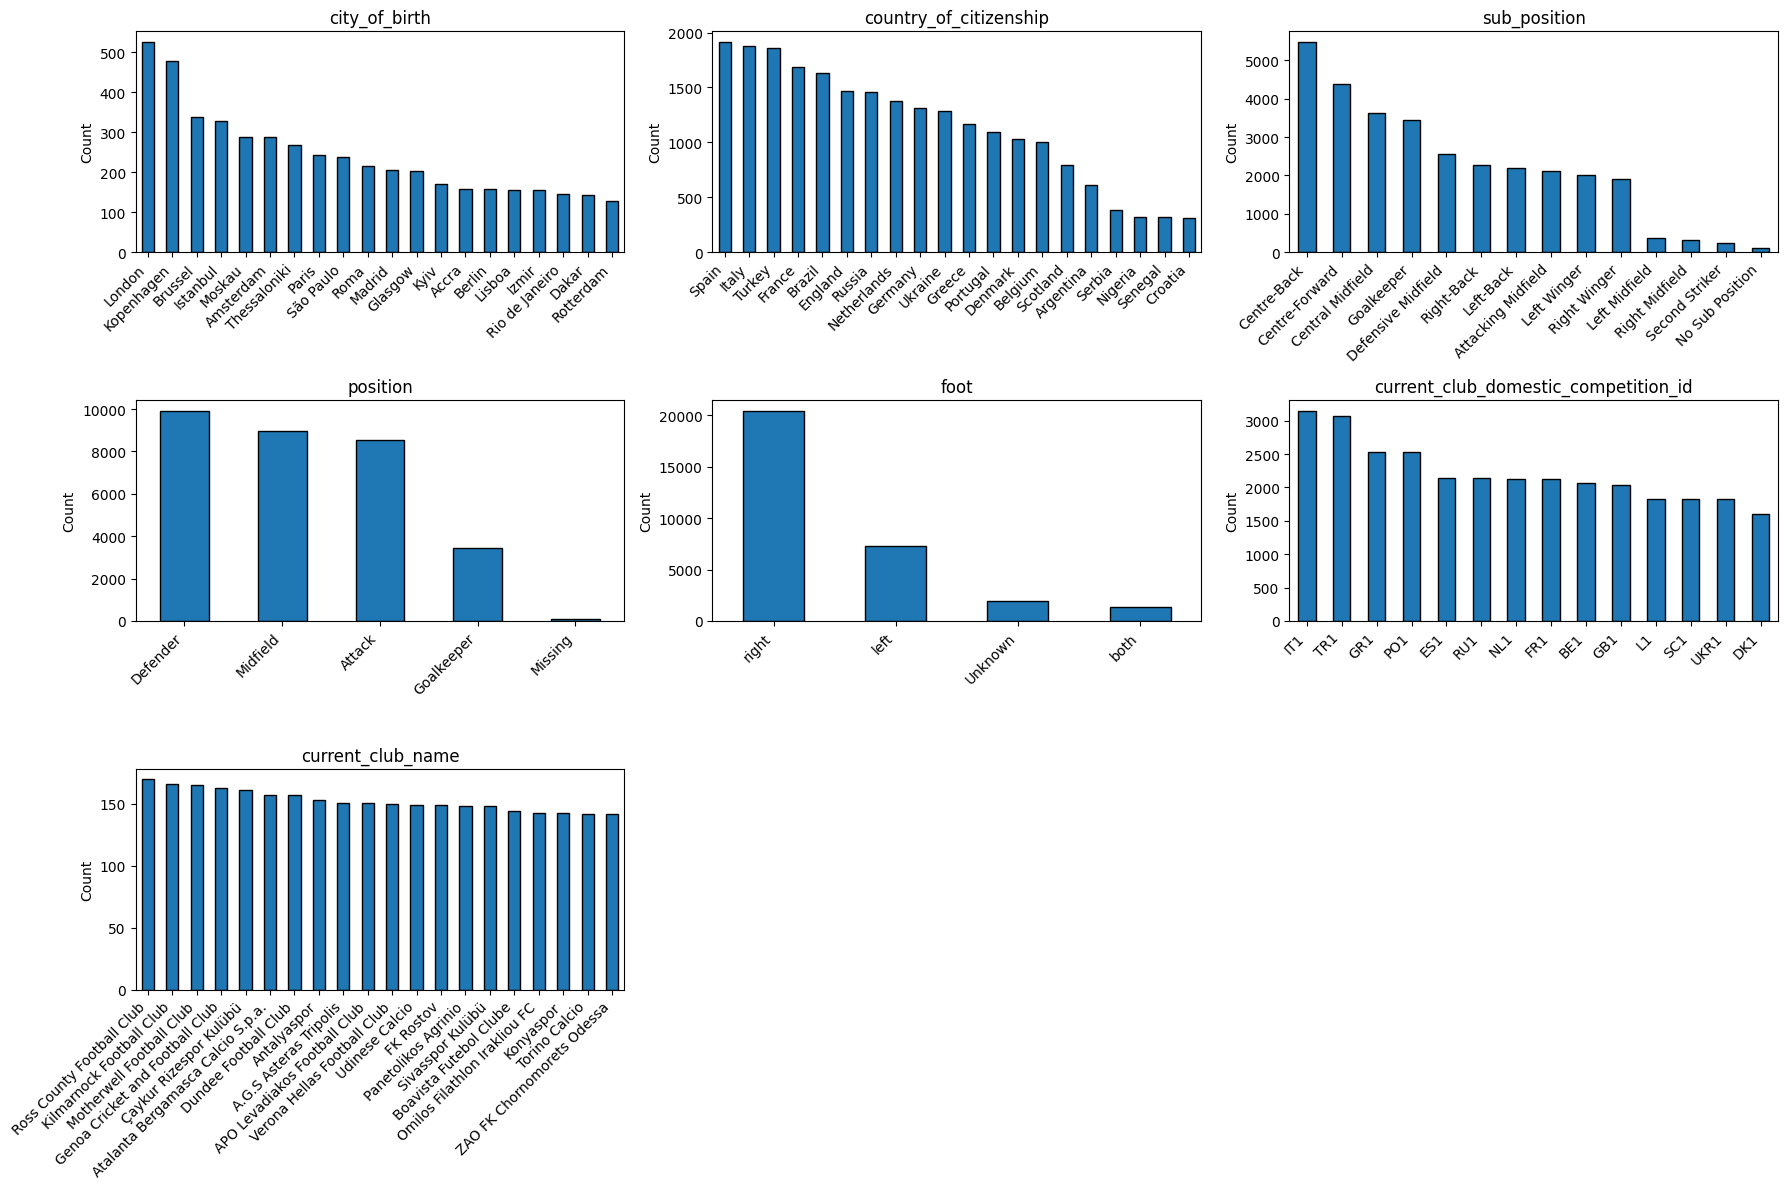

In [14]:
n = len(categorical_columns)
rows = (n // 3) + 1
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    value_counts = players[col].value_counts().head(20)
    value_counts.plot(kind='bar', ax=axes[i], edgecolor='black')

    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

    axes[i].tick_params(axis='x', rotation=45)
    for label in axes[i].get_xticklabels():
        label.set_horizontalalignment('right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31046 entries, 0 to 31045
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             31046 non-null  int64         
 1   first_name                            31046 non-null  object        
 2   last_name                             31046 non-null  object        
 3   name                                  31046 non-null  object        
 4   last_season                           31046 non-null  int64         
 5   current_club_id                       31046 non-null  int64         
 6   player_code                           31046 non-null  object        
 7   city_of_birth                         31046 non-null  object        
 8   country_of_citizenship                31046 non-null  object        
 9   date_of_birth                         31046 non-null  datetime64[ns]
 10

# 2️⃣ Ausreißer Analyse

## Numerische Werte

In [16]:
numerical_outliers = []

for col in numerics_columns:
    Q1 = players[col].quantile(0.25)
    Q3 = players[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = players[(players[col] < lower_bound) | (players[col] > upper_bound)][col]
    numerical_outliers.append({
        'feature': col,
        'num_outliers': outliers.shape[0],
        'pct_outliers': round(outliers.shape[0] / players.shape[0] * 100, 2)
    })

outlier_df = pd.DataFrame(numerical_outliers).sort_values('pct_outliers', ascending=False)
outlier_df

feature  num_outliers  pct_outliers
16           contract_years_left          6454         20.79
8      total_captain_appearances          5438         17.52
5             total_transfer_fee          5271         16.98
13                 total_assists          4714         15.18
11               total_red_cards          4663         15.02
2            market_value_in_eur          4387         14.13
12                   total_goals          3941         12.69
3    highest_market_value_in_eur          3736         12.03
6         total_starting_lineups          3144         10.13
10            total_yellow_cards          2928          9.43
14          total_minutes_played          2876          9.26
4            number_of_transfers          2407          7.75
9                    total_games          2400          7.73
7   total_substitute_appearances          1939          6.25
1                   height_in_cm           134          0.43
15                           age            30          0.10
0                    last_season             0          0.00

pct_outliers = Anzahl der Ausreißer in dieser Spalte / Gesamtzahl der Zeilen * 100

Was auf den ersten Blick auffällt:

Viele Variablen haben überraschend viele Ausreißer

- Fast alle Top-Features haben zweistellige pct_outliers-Werte (zwischen 9 % und 21 %).
- Das bedeutet: viele Variablen sind stark schief verteilt, vermutlich rechtsschief (viele kleine Werte, wenige extreme große).
- 'contract_year_left' kommt daher zu Stande, weil bei der Datenverarbeitung fehlende Werte einfach auf "0" gesetzt wurden.


Interpretation:
Im Fußball ist das logisch – es gibt eine Verteilung:
- die meisten Spieler haben moderate Marktwerte,
- wenige Superstars haben extreme Werte → statistisch als Ausreißer markiert, aber inhaltlich realistisch.

### 'market_value_in_eur' Log-Transformation

In [17]:
players['log_market_value'] = np.log1p(players['market_value_in_eur'])

## Kategorische Werte

In [18]:
from fuzzywuzzy import process

unique_countries = players['country_of_citizenship'].dropna().unique()
for country in unique_countries[:10]:
    matches = process.extract(country, unique_countries, limit=5)
    print(f"{country}: {matches}")

print("-------")

unique_cities = players["city_of_birth"].dropna().unique()
for city in unique_cities[:10]:
    matches = process.extract(city, unique_cities, limit=5)
    print(f"{city}: {matches}")

Germany: [('Germany', 100), ('Iran', 68), ('Georgia', 57), ('Romania', 57), ('Nigeria', 57)]
Bulgaria: [('Bulgaria', 100), ('Algeria', 67), ('Iran', 60), ('Iraq', 60), ('Latvia', 57)]
Brazil: [('Brazil', 100), ('Israel', 50), ('Croatia', 46), ('Ukraine', 46), ('Romania', 46)]
Czech Republic: [('Czech Republic', 100), ('Central African Republic', 86), ('Dominican Republic', 69), ('Chile', 54), ('Belgium', 50)]
Paraguay: [('Paraguay', 100), ('Uruguay', 67), ('Panama', 57), ('Peru', 50), ('Equatorial Guinea', 48)]
Hungary: [('Hungary', 100), ('Uruguay', 57), ('Bulgaria', 53), ('Ghana', 50), ('Lithuania', 50)]
Denmark: [('Denmark', 100), ('Kenya', 50), ('Sweden', 46), ('Panama', 46), ('Mali', 45)]
Georgia: [('Georgia', 100), ('Nigeria', 71), ('Algeria', 71), ('Serbia', 62), ('Iran', 60)]
North Macedonia: [('North Macedonia', 100), ('Estonia', 69), ('Iran', 64), ('Iraq', 60), ('Indonesia', 56)]
Peru: [('Peru', 100), ('Cyprus', 68), ('Guadeloupe', 60), ('Belarus', 55), ('Paraguay', 50)]
----

/Users/antonioaleksic/Documents/ADSC21/.venv/lib/python3.13/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Opole: [('Opole', 100), ('Stavropol', 80), ('Melitopol', 80), ('Simferopol', 80), ('Poole', 80)]
Diez: [('Diez', 100), ('Sanlúcar de Barrameda (Cádiz)', 77), ('Capitán Bermúdez', 77), ('San Fernando (Cádiz)', 77), ('Balmedie', 77)]
Blagoevgrad: [('Blagoevgrad', 100), ('La', 90), ('Riad', 77), ('Lagos', 72), ('Lages', 72)]
Brasília: [('Brasília', 100), ('Brasilia', 93), ('As', 90), ('Bastia', 77), ('Lima', 77)]
Freital: [('Freital', 100), ('Re', 90), ('Tala', 77), ('Lauro de Freitas', 77), ('Teixeira de Freitas', 77)]
Belo Horizonte: [('Belo Horizonte', 100), ('Ho', 90), ('Belo Monte', 75), ('Ripon', 72), ('Osório', 72)]
Haltern: [('Haltern', 100), ('Halden', 77), ('Holten', 77), ('Frederico Westphalen', 75), ('Räng', 72)]
Praha: [('Praha', 100), ('Praïa', 89), ('Praia', 80), ('Piranhas', 77), ('Palhoça', 73)]
Blieskastel: [('Blieskastel', 100), ('Sète', 90), ('As', 90), ('Kassel', 75), ('Sastre', 75)]
Asunción: [('Asunción', 100), ('Nueva Guatemala de la Asunción', 90), ('As', 90), ('I

- sieht soweit i. O. aus

# 3️⃣ Spielerprofil-Analyse

## Alter vs. Marktwert

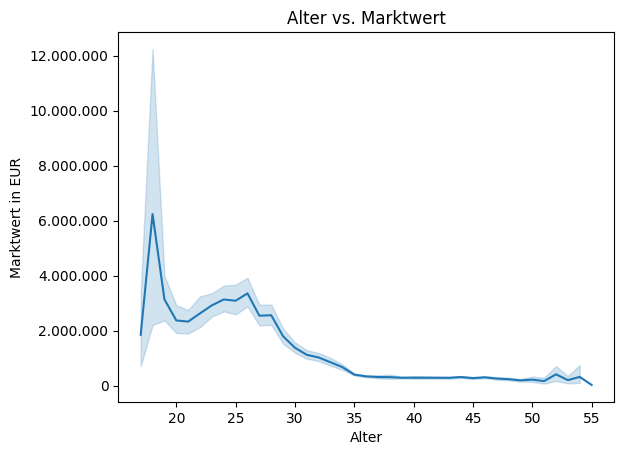

In [19]:
sns.lineplot(data=players, x="age", y="market_value_in_eur")

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.xlabel("Alter")
plt.ylabel("Marktwert in EUR")
plt.title("Alter vs. Marktwert")
plt.show()

- Junge Spieler mehr Wert und ein Peak nochmal mit 27 Jahre ca.

## Altersverteilung pro Position 

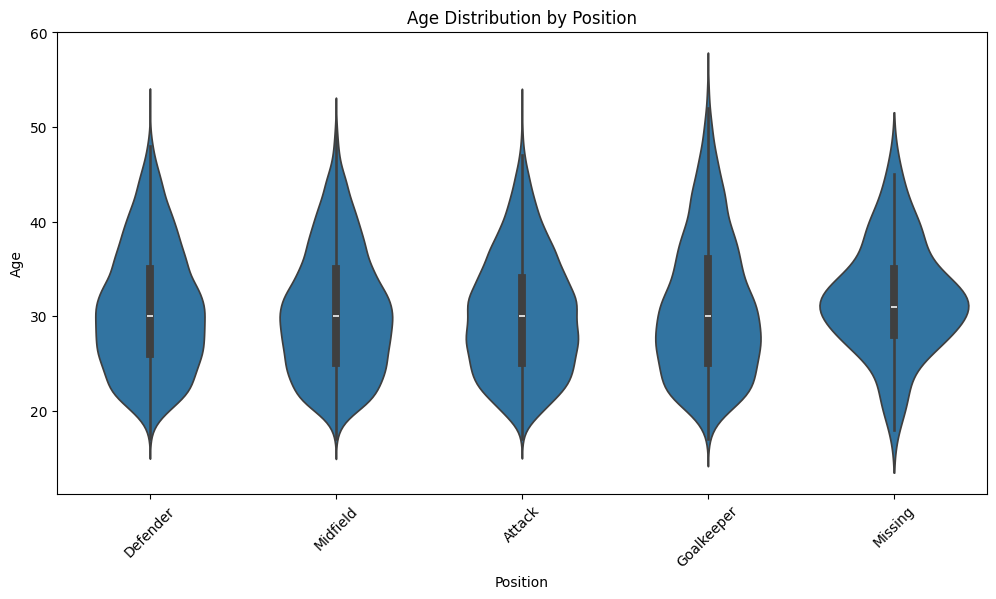

In [20]:
plt.figure(figsize=(12,6))
sns.violinplot(
    data=players,
    x='position',
    y='age',
    order=players['position'].value_counts().index,  # sortiere nach Häufigkeit
    inner='box'
)
plt.title('Age Distribution by Position')
plt.xlabel('Position')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

- Torwärte sind tendenziell ein wenig älter

## Größe vs. Position

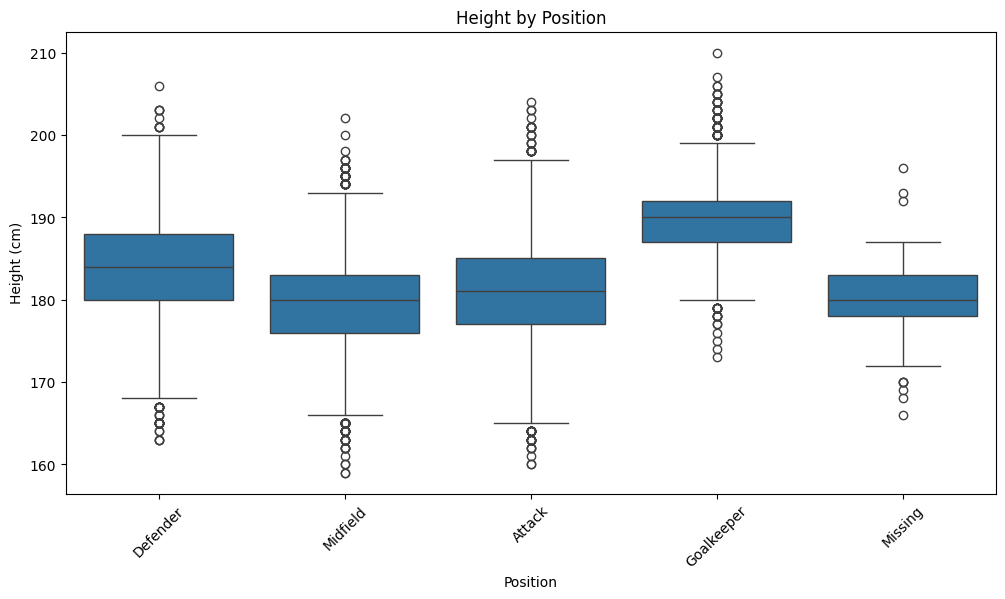

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=players,
    x='position',
    y='height_in_cm',
    order=players['position'].value_counts().index
)
plt.title('Height by Position')
plt.xlabel('Position')
plt.ylabel('Height (cm)')
plt.xticks(rotation=45)
plt.show()

- Da wo Höhe eine gute Eigenschaft ist, sind diese auch in den Position vertreten

## Starker Fuß – Marktwert nach Fuß

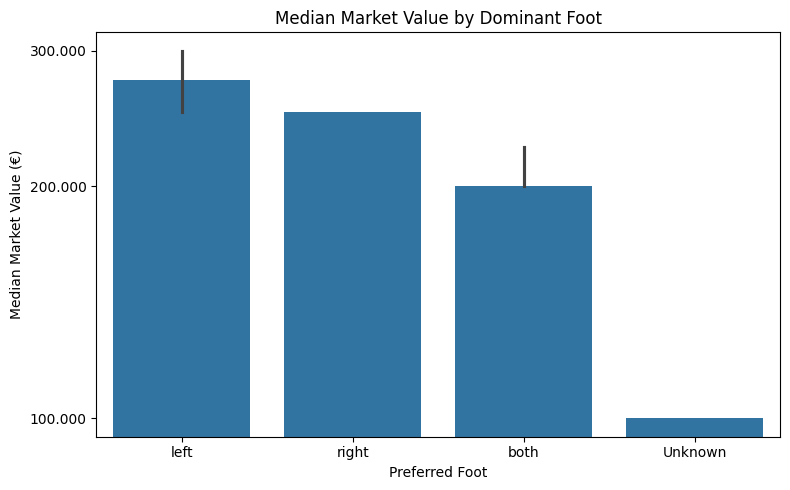

In [22]:
foot_order = (
    players.groupby('foot')['market_value_in_eur'].median()
    .sort_values(ascending=False).index
)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=players,
    x='foot',
    y='market_value_in_eur',
    order=foot_order,
    estimator=np.median,
    ax=ax
)

ax.set_title('Median Market Value by Dominant Foot')
ax.set_xlabel('Preferred Foot')
ax.set_ylabel('Median Market Value (€)')

ax.set_yscale('log')

ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1.0, 2.0, 3.0)))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}".replace(",", ".")))

plt.tight_layout()
plt.show()

- Beidfüßige unerwartet weit hinten mit dem Marktwert, eventuell weil es zu wenige gibt?

# 4️⃣ Karriere- & Leistungsdaten

## Spielzeit vs. Marktwert

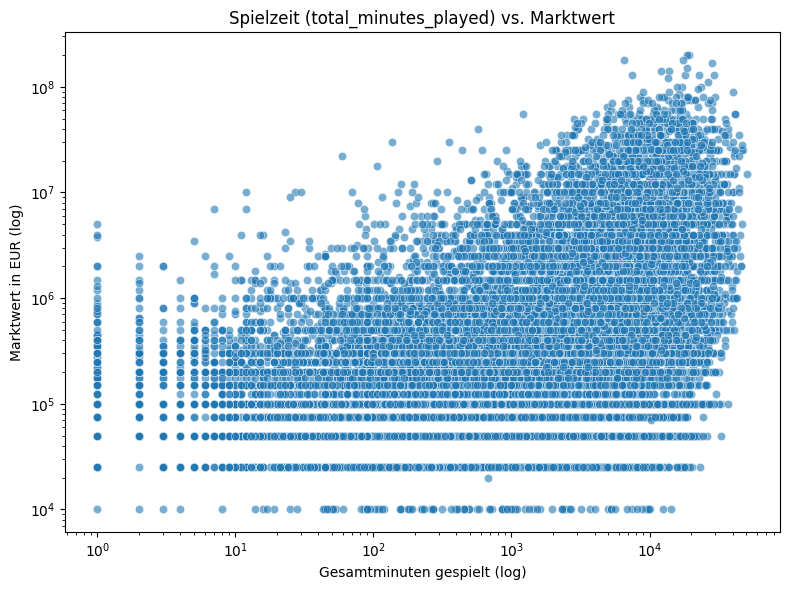

In [23]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=players,
    x="total_minutes_played",
    y="market_value_in_eur",
    alpha=0.6,
)

plt.xscale("log")
plt.yscale("log")
plt.title("Spielzeit (total_minutes_played) vs. Marktwert")
plt.xlabel("Gesamtminuten gespielt (log)")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- Je mehr Spielminuten ein Spieler gesammelt hat, desto höher tendenziell sein Marktwert

## Tore vs. Marktwert

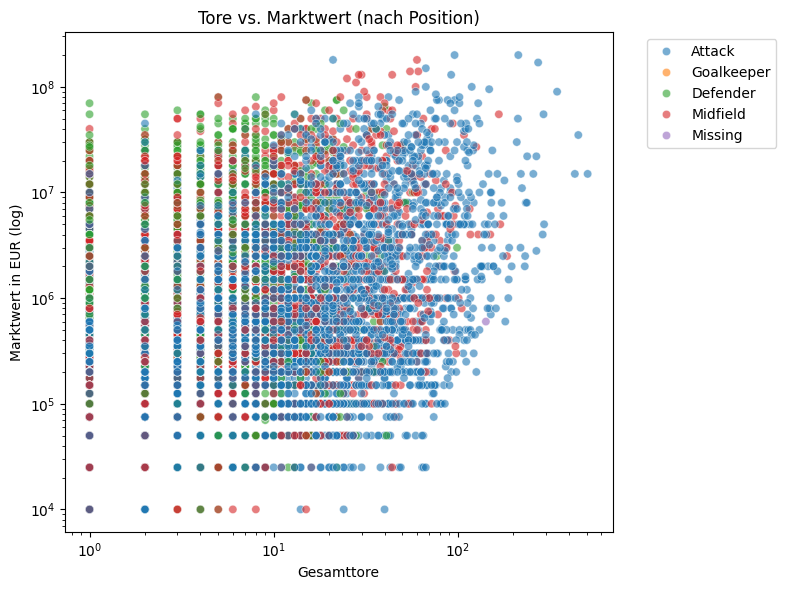

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=players,
    x="total_goals",
    y="market_value_in_eur",
    hue="position",
    alpha=0.6
)
plt.yscale("log")
plt.xscale("log")
plt.title("Tore vs. Marktwert (nach Position)")
plt.xlabel("Gesamttore")
plt.ylabel("Marktwert in EUR (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- es gibt eine leichte Tendenz, Spieler mit mehr Toren haben im Schnitt einen höheren Marktwert (-> gerade bei Angreifern)

## Assists vs. Marktwert

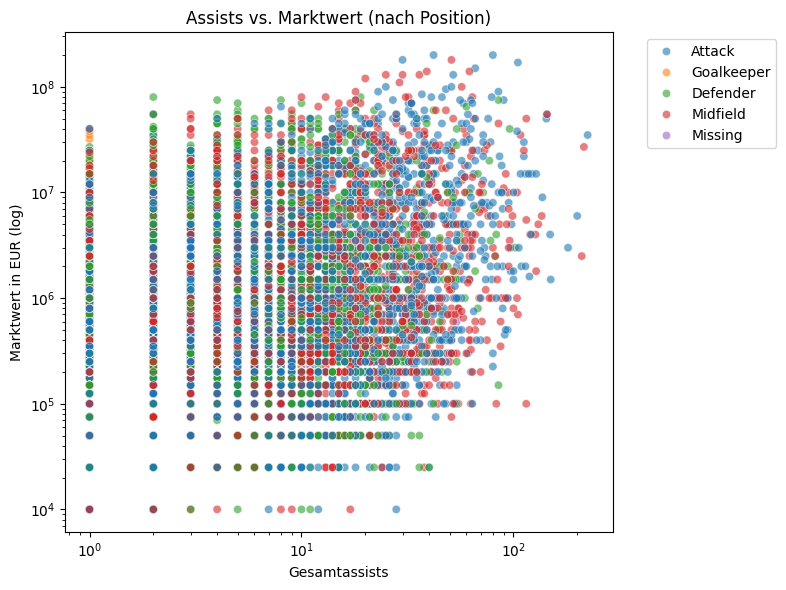

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=players,
    x="total_assists",
    y="market_value_in_eur",
    hue="position",
    alpha=0.6
)
plt.yscale("log")
plt.xscale("log")
plt.title("Assists vs. Marktwert (nach Position)")
plt.xlabel("Gesamtassists")
plt.ylabel("Marktwert in EUR (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- je mehr Assists ein Spieler über seine Karriere gesammelt hat, desto höher tendenziell sein Marktwert (gerade wenn Assists > 10)

## Gelbe Karten vs. Marktwert

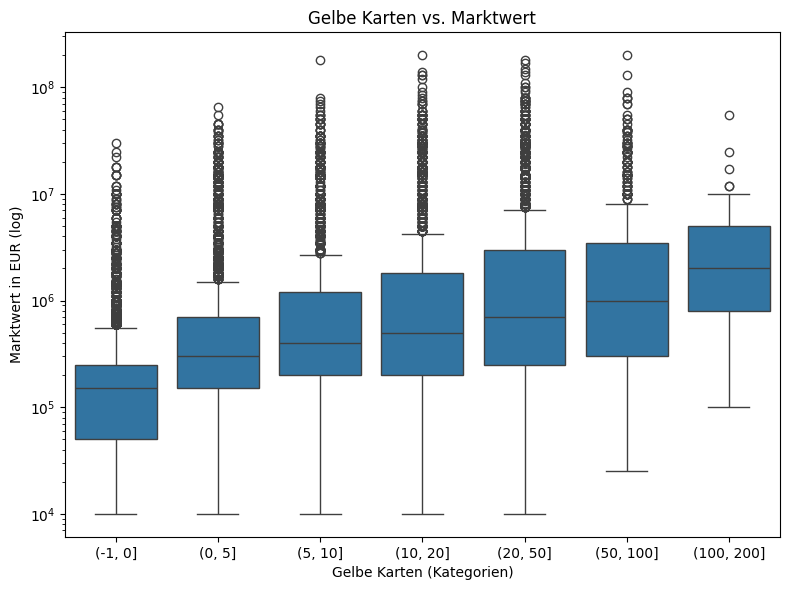

In [26]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=players,
    x=pd.cut(players["total_yellow_cards"], bins=[-1, 0, 5, 10, 20, 50, 100, 200]),
    y="market_value_in_eur"
)
plt.yscale("log")
plt.title("Gelbe Karten vs. Marktwert")
plt.xlabel("Gelbe Karten (Kategorien)")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- Gelbe Karten scheinen nicht negativ mit dem Marktwert zusammenzuhängen
- Im Gegenteil - leichte positive Korrelation → Spieler mit vielen Einsätzen bekommen naturgemäß mehr Karten
- Das ist also eher ein indirekter Effekt über Spielzeit
    - Mehr Einsätze → mehr Karten → gleichzeitig höherer Marktwert
    - Nicht: „mehr Karten = wertvoller“

## Rote Karten vs. Marktwert

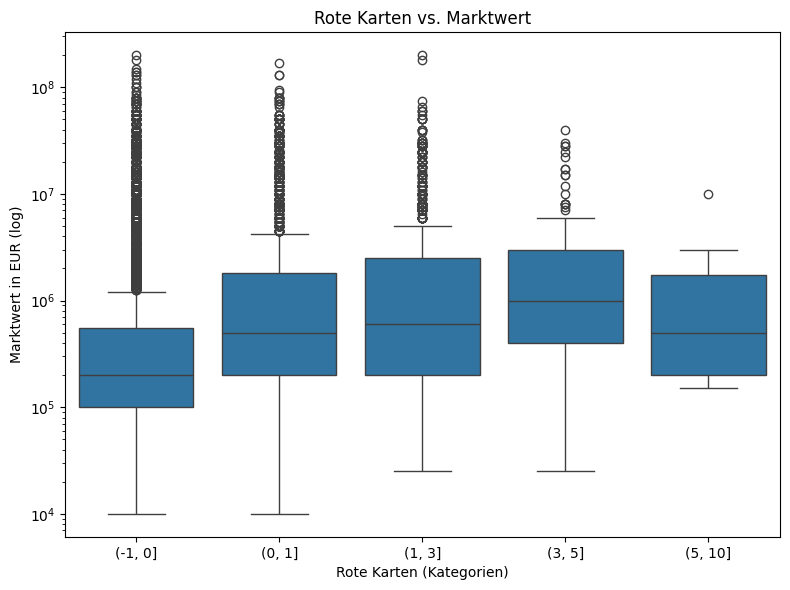

In [27]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=players,
    x=pd.cut(players["total_red_cards"], bins=[-1,0,1,3,5,10]),
    y="market_value_in_eur"
)
plt.yscale("log")
plt.title("Rote Karten vs. Marktwert")
plt.xlabel("Rote Karten (Kategorien)")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- Rote Karten scheinen keine wesentliche Rolle für den Marktwert zu spielen

## Anzahl Transfers vs. Marktwert

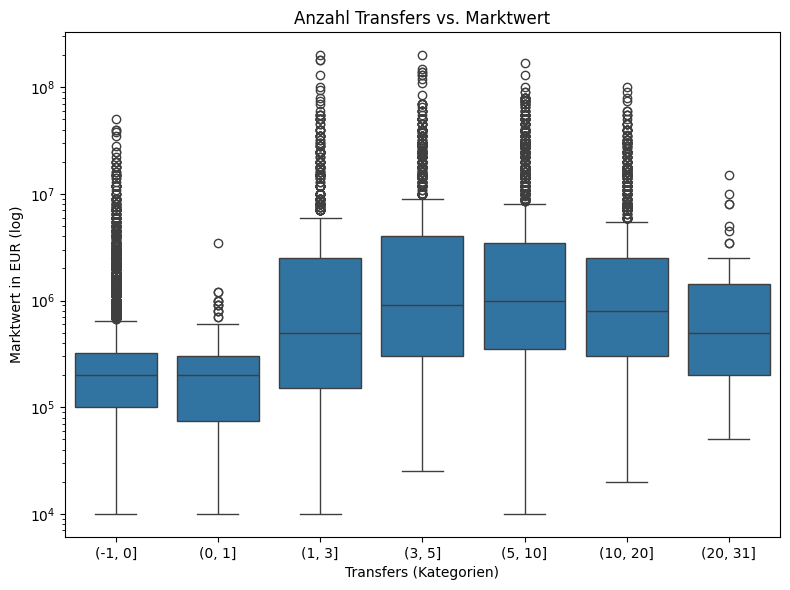

In [28]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=players,
    x=pd.cut(players["number_of_transfers"], bins=[-1, 0, 1, 3, 5, 10, 20, 31]),
    y="market_value_in_eur"
)
plt.yscale("log")
plt.title("Anzahl Transfers vs. Marktwert")
plt.xlabel("Transfers (Kategorien)")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- Marktwert steigt mit zunehmender Transfererfahrung zunächst an (bis ~5 Transfers), stabilisiert sich dann und fällt leicht bei „Wandervögeln“ mit vielen Vereinswechseln – ein typisches Muster für Karriereverlauf und Marktwertentwicklung

## Gesamttransfersumme vs. Marktwert

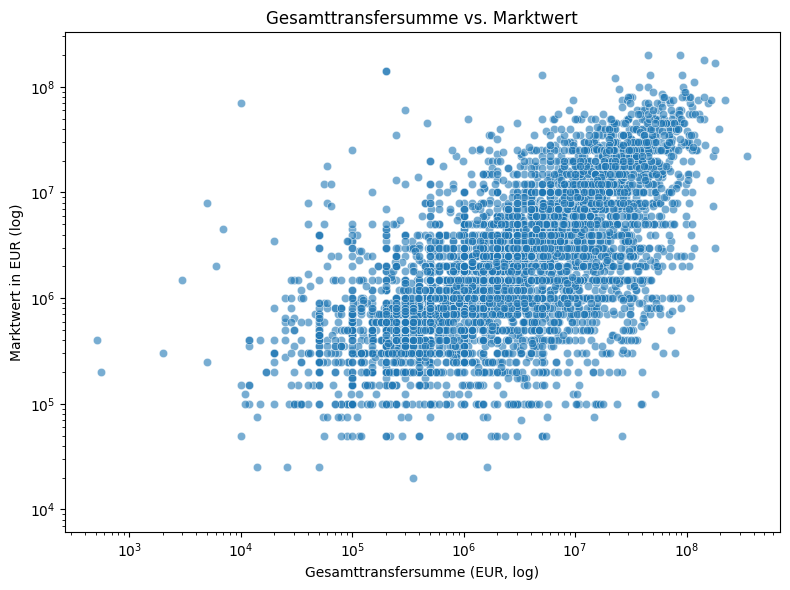

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=players,
    x="total_transfer_fee",
    y="market_value_in_eur",
    alpha=0.6
)
plt.xscale("log")
plt.yscale("log")
plt.title("Gesamttransfersumme vs. Marktwert")
plt.xlabel("Gesamttransfersumme (EUR, log)")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- je mehr Geld in Transfers für Spieler, desto höher ist in der Regel sein Marktwert – die Gesamttransfersumme ist damit ein starker Indikator für Marktvertrauen und Leistungsniveau, zeigt aber auch Sättigungseffekte bei Topspielern

# 5️⃣ Positionale Unterschiede

## Marktwert nach Position

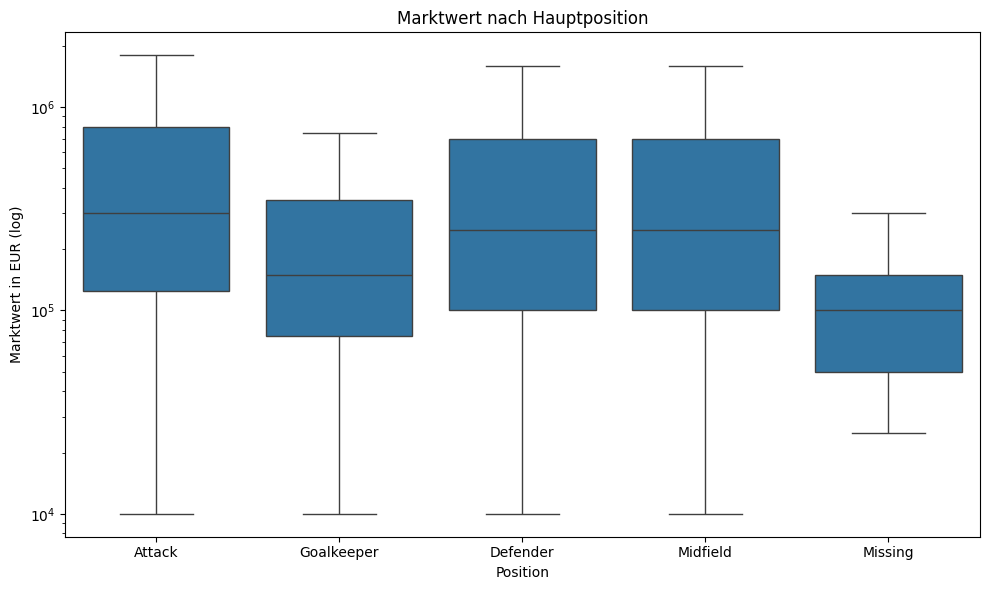

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=players,
    x="position",
    y="market_value_in_eur",
    showfliers=False
)
plt.yscale("log")
plt.title("Marktwert nach Hauptposition")
plt.xlabel("Position")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

- Stürmer und offensive Mittelfeldspieler dominieren den Marktwert, Verteidiger und Torhüter folgen mit deutlichem Abstand
- Der Markt honoriert offensive Wirkung und Torgefahr überproportional — defensive Qualität wird dagegen strukturell niedriger bewertet

## Leistungsmetriken positionsspezifisch

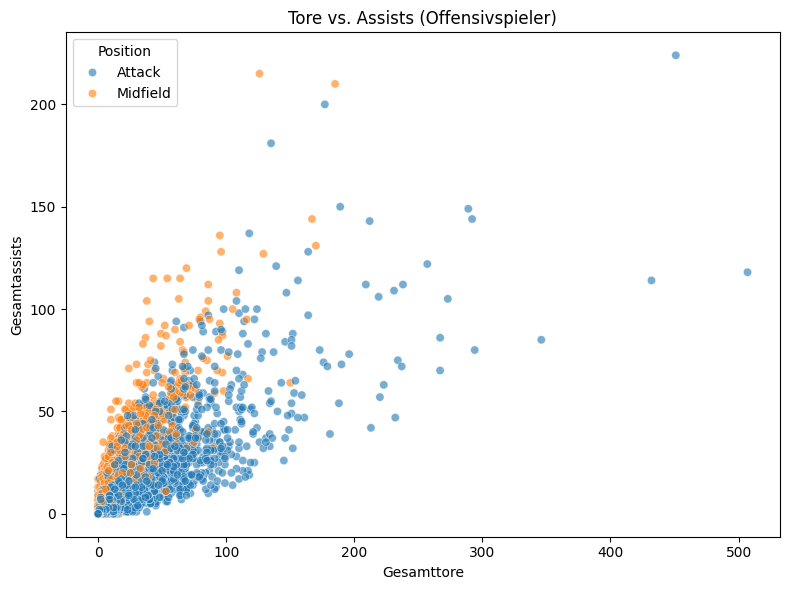

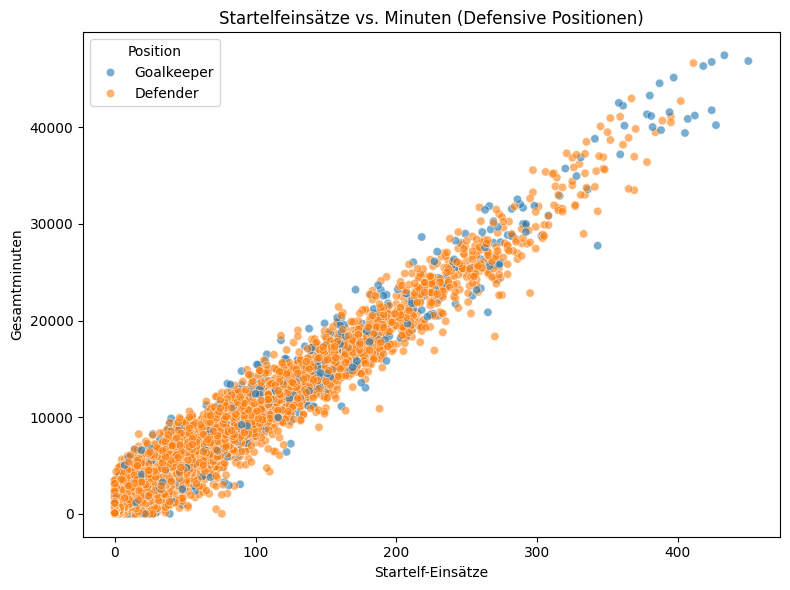

In [31]:
# a) Tore & Assists für Stürmer / Mittelfeld
plt.figure(figsize=(8,6))
subset_attack_mid = players[players["position"].isin(["Attack", "Midfield"])]
sns.scatterplot(
    data=subset_attack_mid,
    x="total_goals",
    y="total_assists",
    hue="position",
    alpha=0.6
)
plt.title("Tore vs. Assists (Offensivspieler)")
plt.xlabel("Gesamttore")
plt.ylabel("Gesamtassists")
plt.legend(title="Position", loc="upper left")
plt.tight_layout()
plt.show()

# b) Startelf & Minuten für Verteidiger / Torhüter
plt.figure(figsize=(8,6))
subset_def_gk = players[players["position"].isin(["Defender", "Goalkeeper"])]
sns.scatterplot(
    data=subset_def_gk,
    x="total_starting_lineups",
    y="total_minutes_played",
    hue="position",
    alpha=0.6
)
plt.title("Startelfeinsätze vs. Minuten (Defensive Positionen)")
plt.xlabel("Startelf-Einsätze")
plt.ylabel("Gesamtminuten")
plt.legend(title="Position", loc="upper left")
plt.tight_layout()
plt.show()

- Bei Offensivspielern korrelieren Tore und Assists stark miteinander – produktive Stürmer und Spielmacher erzielen die höchsten Marktwerte
- Bei defensiven Positionen (Verteidiger & Torhüter) sind konstante Startelfeinsätze und hohe Spielminuten der entscheidende Marktwerttreiber – individuelle Highlights spielen hier kaum eine Rolle

## Marktwert und Leistung je Position

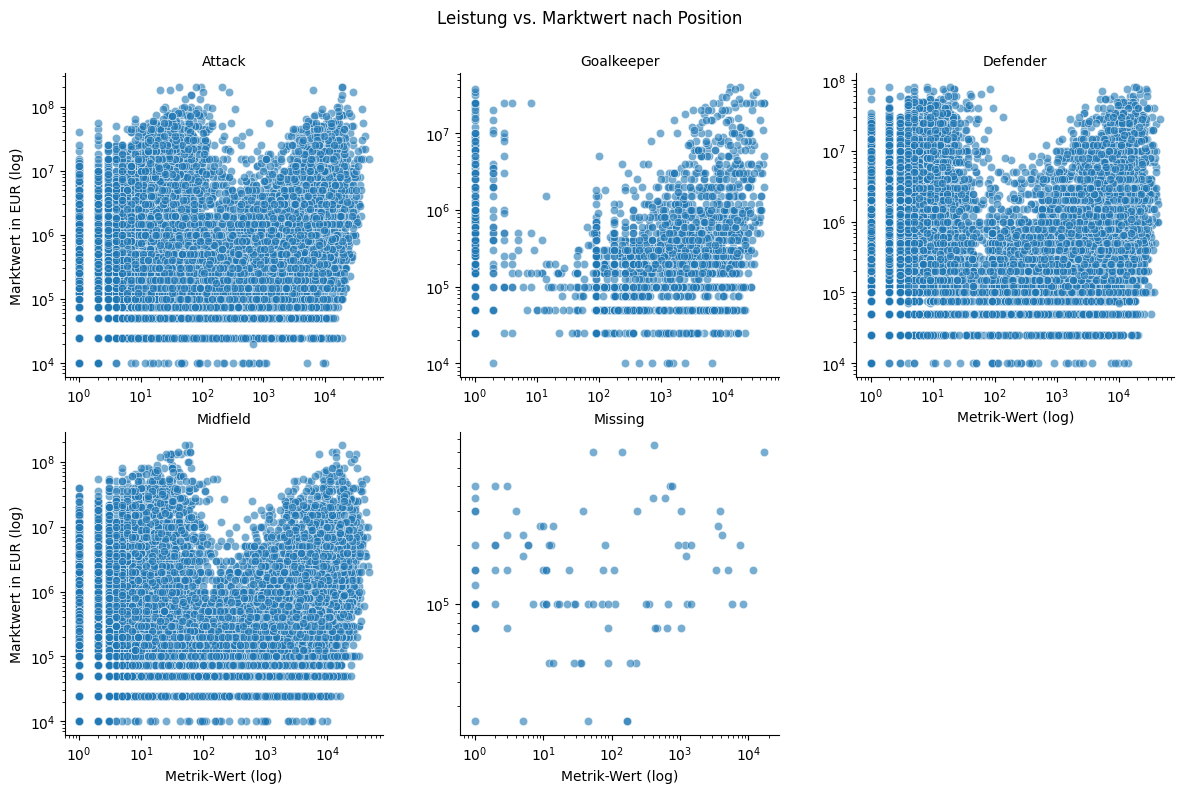

In [32]:
metrics = ["total_goals", "total_assists", "total_minutes_played"]
df_melt = players.melt(
    id_vars=["position", "market_value_in_eur"],
    value_vars=metrics,
    var_name="metric",
    value_name="value"
)

g = sns.FacetGrid(df_melt, col="position", col_wrap=3, height=4, sharey=False, sharex=False)
g.map_dataframe(
    sns.scatterplot,
    x="value", y="market_value_in_eur",
    alpha=0.6
)
for ax in g.axes:
    ax.set_yscale("log")
    ax.set_xscale("log")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Metrik-Wert (log)", "Marktwert in EUR (log)")
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Leistung vs. Marktwert nach Position")
plt.show()

- Der Markt reagiert positionsspezifisch auf Leistung:
    - Offensivspieler profitieren stark von individuellen Outputmetriken (Tore, Assists)
	- Mittelfeld- und Defensivspieler werden stabiler, aber weniger stark leistungsabhängig bewertet
	- Torhütermarkt ist am homogensten – Spielzeit zählt, nicht Einzelaktionen

## Durchschnittswerte pro Position

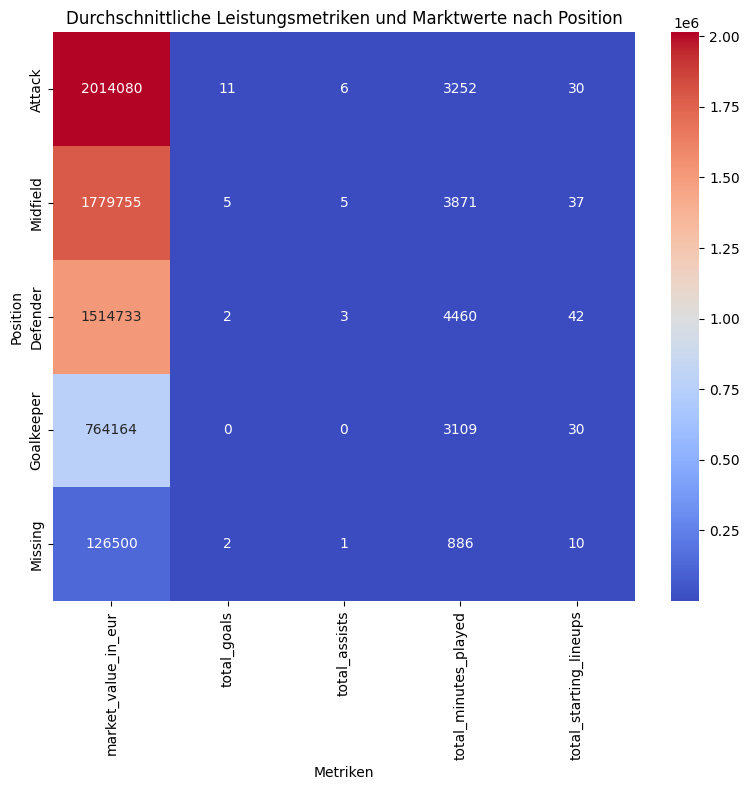

In [33]:
pos_summary = players.groupby("position")[[
    "market_value_in_eur",
    "total_goals",
    "total_assists",
    "total_minutes_played",
    "total_starting_lineups"
]].mean().sort_values("market_value_in_eur", ascending=False)

plt.figure(figsize=(8,8))
sns.heatmap(pos_summary, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Durchschnittliche Leistungsmetriken und Marktwerte nach Position")
plt.xlabel("Metriken")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

- Der Markt belohnt offensive Positionen am stärksten
- Stürmer > Mittelfeld > Verteidiger > Torhüter — ein Muster, das sich in allen Transfermarkt-Analysen zeigt
- → Offensivwirkung (Tore/Assists) ist für den Marktwert entscheidend

# 6️⃣ Zeitliche Komponenten

## Alter bei höchstem Marktwert

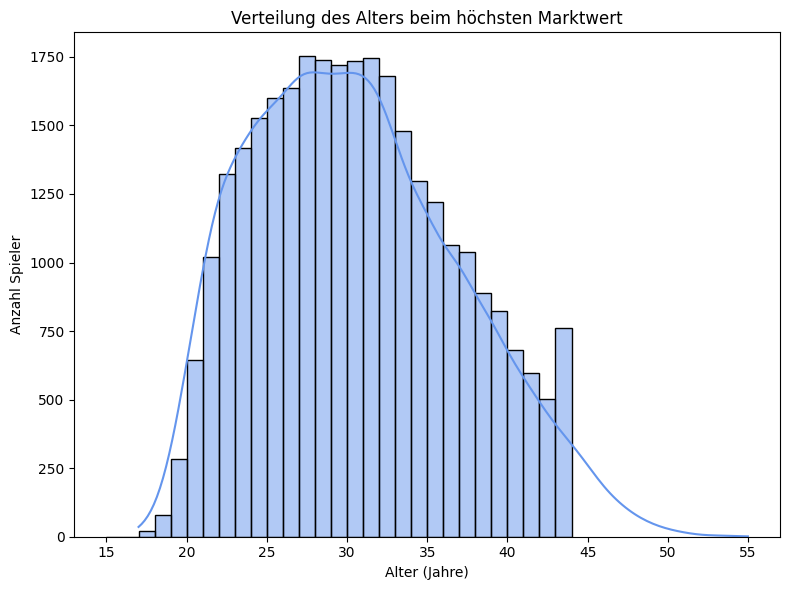

In [34]:
plt.figure(figsize=(8,6))
sns.histplot(
    data=players,
    x="age",
    bins=range(15,45),
    kde=True,
    color="cornflowerblue"
)
plt.title("Verteilung des Alters beim höchsten Marktwert")
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Spieler")
plt.tight_layout()
plt.show()

- Alter ist ein nichtlinearer Prädiktor - Der Marktwert steigt mit Alter bis etwa 27 – 29 Jahre und fällt dann wieder ab.

## Vertragslaufzeit vs. Marktwert

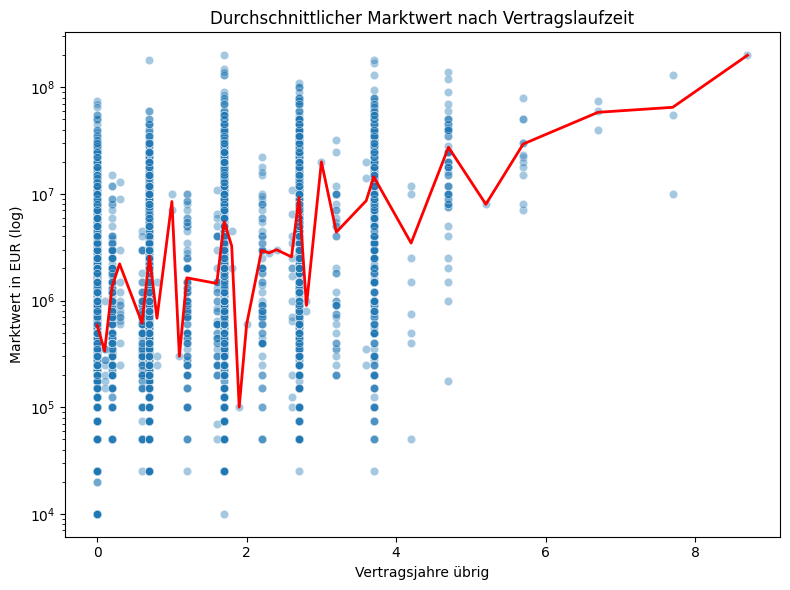

In [35]:
contract_summary = players.groupby("contract_years_left")["market_value_in_eur"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(data=players, x="contract_years_left", y="market_value_in_eur", alpha=0.4)
sns.lineplot(data=contract_summary, x="contract_years_left", y="market_value_in_eur", color="red", lw=2)
plt.yscale("log")
plt.title("Durchschnittlicher Marktwert nach Vertragslaufzeit")
plt.xlabel("Vertragsjahre übrig")
plt.ylabel("Marktwert in EUR (log)")
plt.tight_layout()
plt.show()

Die Analyse zeigt, dass die verbleibende Vertragslaufzeit einen klaren Einfluss auf den Marktwert eines Spielers hat.
Spieler mit längeren Restlaufzeiten (3–5 Jahre) weisen im Durchschnitt höhere Marktwerte auf als solche, deren Verträge bald auslaufen.
Kurz vor Vertragsende (≤ 1 Jahr) ist ein deutlicher Wertverlust zu beobachten, was auf erwartete Ablösefreiheit und geringere Verhandlungsmacht der Vereine zurückzuführen ist.
Der Effekt ist nicht linear – besonders bei Top-Spielern mit langen Verträgen sind überproportional hohe Marktwerte zu erkennen.

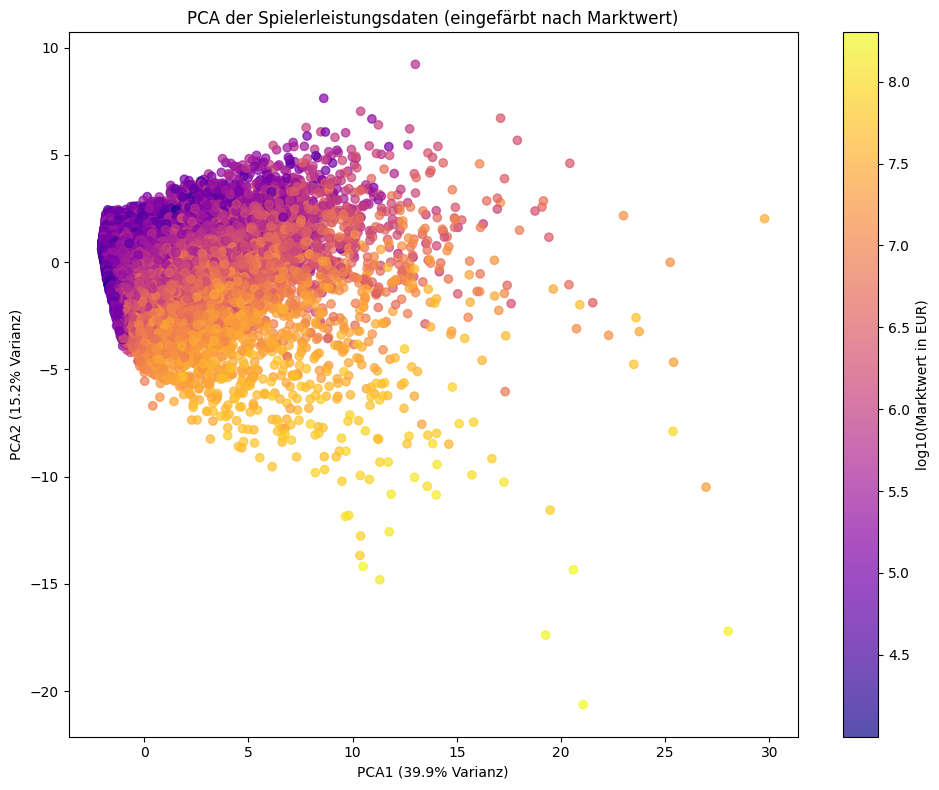